# A neural network approach to solve Schrodinger equation

## Motivation:
[Universal approximation theorem](http://mcneela.github.io/machine_learning/2017/03/21/Universal-Approximation-Theorem.html) proved that **ANY** function can be approximated by a neural network with one hidden layer, using a bounded, countinuous, monotonically increasing activation function [[Hornik](http://zmjones.com/static/statistical-learning/hornik-nn-1991.pdf)].

If the Schrodinger equation solver is formulated as the approximator to estimate molecular orbital coefficients, for a given basis set and assuming that the activation function satisfies the necessary condition. The limit of exact approximator exist. It is therefore interesting how well this approximator can be modeled.

## A naive network structure:
### input layer $\rightarrow$ hidden layer(s) $\rightarrow$ output layer

* Input layer: Given basis set $\{g_{\alpha}(\mathbf{r})\}_{\alpha}$, and number of electrons $N$, and structure file, containing nuclear positions $\{\mathbf{R}_I\}_I$ and the correspoinding nuclear charge $\{Z_I\}_I$. Compute the following:
 * Overlap matrix $[\mathbf{S}]_{\alpha\beta}=\int d\mathbf{r} g_\alpha(\mathbf{r})g_\beta(\mathbf{r})$
 * Canonical orthogonalization matrix $\mathbf{X} = \mathbf{U} / \sqrt{\mathbf{D}}$
 * Kinetic energy matrix $[\mathbf{K}]_{\alpha\beta} = -\frac{1}{2}\int d\mathbf{r}g_\alpha(\mathbf{r})\nabla^2 g_\beta(\mathbf{r})$
 * External potential matrix $[\mathbf{V}]_{\alpha\beta} = -\sum_I\int d\mathbf{r}\frac{g_\alpha(\mathbf{r})g_\beta(\mathbf{r})}{|\mathbf{r} - \mathbf{R}_I|}Z_I$
 * Electron repulsion matrix $[\mathbf{ER}]_{\alpha\beta\gamma\delta} = \int d\mathbf{r} d\mathbf{r}'\frac{g_\alpha(\mathbf{r})g_\beta(\mathbf{r})g_\gamma(\mathbf{r}')g_\delta(\mathbf{r}')}{|\mathbf{r}-\mathbf{r}'|}$
 * Initialize molecular orbital coefficients (MOV) $\mathbf{C_0}$ (initial guess).
* Hidden recurrent layer: Given a maximum iteration number $T$, update MOV by the recursive function with variables  weights $\mathbf{W}_t$, and bias $\mathbf{b}_t$
$$
\mathbf{C}_{t} = \mathbf{\sigma}(\mathbf{C}_{t-1}\cdot\mathbf{W}_t + \mathbf{b}_t) = \mathbf{X}\cdot f_{\mathrm{eig}}\Big((\mathbf{C}_{t-1}\cdot\mathbf{W}_t + \mathbf{b}_t)^{\mathrm{T}}\cdot(\mathbf{C}_{t-1}\cdot\mathbf{W}_t + \mathbf{b}_t)\Big),
$$
where $\mathbf{\sigma}([\cdot]) = \mathbf{X}\cdot f_{\mathrm{eig}}([\cdot]^{\mathrm{T}}[\cdot]): \mathbb{R}^{m\times m}\rightarrow\mathbb{R}^{m\times m}$ is the nonlinear activation function.
Such that $\mathbf{C}_t^{\mathrm{T}}\cdot\mathbf{S}\cdot\mathbf{C}_t = \mathbf{1}\ \forall\ t$
(see section orthogonalization of the basis functions below).
* Output layer: Treat $\mathbf{C}_T$ as the converged Hartree-Fock molecular orbital coefficients and evaluate the Hartree-Fock energy normaly. That is (for conventional closed shell system)
$$
E = K + V + U + X + V_{nn},
$$
with density matrix $[\mathbf{P}]_{\alpha\beta}=2\sum_{i=1}^{N/2} C_{i\alpha}C_{i\beta}$ where 
 * Kinetic energy $K = tr(\mathbf{P}\cdot\mathbf{K})$
 * External pential energy $V = tr(\mathbf{P}\cdot\mathbf{V})$
 * and other terms $\cdots$

## Implementation

* Model construction:
All Gaussian basis matrix element can be evaluated by the ${\tt Horton}$ package. The computational graph (operational connectivity) can be constructed using ${\tt TensorFlow}$. 
* Trainning:
Standard backpropagation should work. There are two possible issues
 * Interface between ${\tt Horton}$ and ${\tt TensorFlow}$
 * Matrix operation derivatives, namely the derivative of trace and eigenvector decomposition in , e.g. $\frac{\partial K}{\partial\mathbf{W}} = \frac{\partial}{\partial\mathbf{W}} tr(\mathbf{P}\cdot\mathbf{K})$
 (see [/root_to_tensorflow/python/ops/linalg_grad.py](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/linalg_grad.py) and the corresponding [documentation](http://eprints.maths.ox.ac.uk/1079/1/NA-08-01.pdf) for details)

## Orthogonalization of the basis functions

Any random combination of Gaussian basis functions can be orthonormalized. An example of H$_2$ molecule using 3-21G basis function is shown

In [1]:
import qctoolkit as qtk
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

%matplotlib inline

clear_output()

Gaussian basis is normalized but not orthogonal to each other, as can be seen by the non-zero off-diagonal matrix element of the overlap matrix $\mathbf{S}$

In [2]:
mol = qtk.QMInp('xyz/h2.xyz', program='horton', basis_set='3-21g')
clear_output()
mol.olp

array([[ 1.        ,  0.64589894,  0.40432958,  0.48051762],
       [ 0.64589894,  1.        ,  0.48051762,  0.8360078 ],
       [ 0.40432958,  0.48051762,  1.        ,  0.64589894],
       [ 0.48051762,  0.8360078 ,  0.64589894,  1.        ]])

However, the molecular orbitals (MO) form a orthonormal basis set,
$$
\langle\psi_i|\psi_j\rangle = \delta_{ij},
$$
where 
$$
\psi_i(\mathbf{r}) = \sum_{\alpha=1}^M c_{i\alpha}g_\alpha(\mathbf{r}),\mbox{ and MO coefficients } [\mathbf{C}]_{i\alpha} = c_{i\alpha}.
$$
That is
$$
\mathbf{C}^{\mathrm{T}}\cdot\mathbf{S}\cdot\mathbf{C} = \mathbf{1}
$$

In [3]:
C = mol.mov
C.T.dot(mol.olp).dot(C)

array([[  1.00000000e+00,  -2.22044605e-16,  -1.11022302e-16,
          2.22044605e-16],
       [ -2.77555756e-17,   1.00000000e+00,   1.11022302e-16,
         -3.33066907e-16],
       [ -1.66533454e-16,  -2.22044605e-16,   1.00000000e+00,
          2.22044605e-16],
       [ -3.46944695e-18,  -9.02056208e-16,   9.71445147e-17,
          1.00000000e+00]])

An orthornormalization matrix $\mathbf{X}$ can be constructed by the overlap matrix $\mathbf{S}$ (canonical orthogonization). 
$$
\mathbf{X} = \mathbf{U}\frac{1}{\sqrt{\mathbf{D}}},
$$
where $\mathbf{D}$ and $\mathbf{U}$ are the eigenvalues and eigenvectors of the overlap matrix $\mathbf{S}$.

Any random combination of basis function can be orothornormalized by orthornormalization matrix.

In [4]:
# canonical orthogonalization transformation matirx
D, U = np.linalg.eig(mol.olp)
X = U / np.sqrt(D)

# random MO coefficients
B = np.random.random(U.shape)
# orthonormalized MO coefficients
C = X.dot(np.linalg.eig(B.T.dot(B))[1])

# orthonormalized random MO coefficients
C.T.dot(mol.olp).dot(C)

array([[  1.00000000e+00,   0.00000000e+00,  -2.22044605e-16,
         -2.22044605e-16],
       [ -2.22044605e-16,   1.00000000e+00,  -1.11022302e-16,
         -3.60822483e-16],
       [ -4.44089210e-16,  -2.77555756e-16,   1.00000000e+00,
          2.77555756e-16],
       [ -3.33066907e-16,  -5.55111512e-17,   5.55111512e-17,
          1.00000000e+00]])

## Construct H$_2$ dataset with varying bond length

In [5]:
inps = []
for R in np.arange(0.3, 3.1, 0.001):
    mol = qtk.Molecule()
    mol.build([[1, 0, 0, 0], [1, R, 0, 0]])
    inp = qtk.QMInp(mol, program='horton', basis_set='3-21g')
    inp.run()
    D, U = np.linalg.eig(inp.olp)
    inp.X = U / np.sqrt(D)
    inps.append(inp)
clear_output()

2520 280


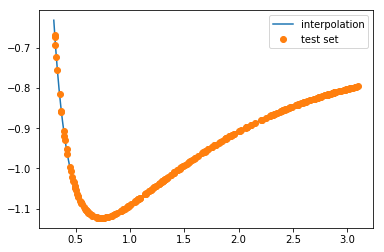

In [6]:
from sklearn.model_selection import train_test_split

inp_train, inp_test = train_test_split(inps, random_state=0, test_size=0.1)

E = [inp.ht_ham.cache['energy'] for inp in inps]
R = [inp.molecule.R[1,0] for inp in inps]
E_train = [inp.ht_ham.cache['energy'] for inp in inp_train]
R_train = [inp.molecule.R[1,0] for inp in inp_train]
E_test = [inp.ht_ham.cache['energy'] for inp in inp_test]
R_test = [inp.molecule.R[1,0] for inp in inp_test]

plt.plot(R, E, label='interpolation')
plt.plot(R_test, E_test, ls='', marker='o', label='test set')
#plt.plot(R_train, E_train, ls='', marker='x', label='training set')
plt.legend(loc=1)
print len(E_train), len(E_test)

### Extract input tensor and compute output Hartree-Fock energy

In [7]:
inp = inps[0]
inp.ht_exp_alpha.occupations

array([ 1.,  0.,  0.,  0.])

In [8]:
# Numpy version implementation

def get_input_tensor(mol):
    """Extract matrices and pack as tensor"""
    S, K, Na, C0, X, Er = mol.olp, mol.kin, mol.na, mol.initial_mov, mol.X, mol.er
    I = np.stack([S, K, Na, C0, X])
    nn = mol.ht_external['nn']
    occ = mol.ht_exp_alpha.occupations
    return I, Er, occ, nn
    
def get_output(I, Er, occ, nn, C):
    """take input tensor and approximated MO coefficients, C, to compute total energy"""
    K = I[1]
    Na = I[2]
    dm = (C * occ).dot(C.T)
    
    Ek = np.trace(dm.dot(K)) * 2
    Ev = np.trace(dm.dot(Na)) * 2
    Ej = np.trace(dm.dot(np.tensordot(dm, Er, axes=([0,1], [0,2])))) * 2
    Ex = -np.trace(dm.dot(np.tensordot(dm, Er, axes=([0,1], [0,1]))))
    E_tot = np.sum([Ek, Ev, Ej, Ex, nn])
    return E_tot

inp = inps[0]
I_np, Er_np, occ, nn = get_input_tensor(inp)
C = inp.ht_exp_alpha.coeffs.__array__()
get_output(I_np, Er_np, occ, nn, C)

-0.63168360801818313

In [9]:
inps[0].run()

Starting plain SCF solver. ndm=1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Iter         Error
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   0   4.35272e-07

Contributions to the energy:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                                              term                 Value
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                                               kin        1.793179024167
                                           hartree        1.715605902722
                                              x_hf       -0.857802951361
                                                ne       -5.046589746486
                                                nn        1.763924162940
                                             total       

## Construct Tensorflow model 

### Tensorflow input interface
Given training or test set, construct stacked input tensors and corresponding labels

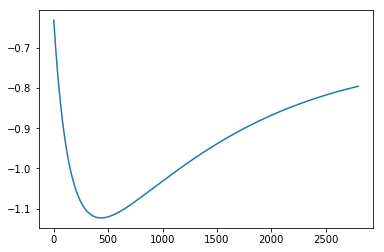

In [10]:
# It is necessary only for batch training

def tfIO(mol_list):
    I_list, Er_list, occ_list, nn_list, C_list, labels = [[] for _ in range(6)]
    for mol in mol_list:
        C = mol.ht_exp_alpha.coeffs.__array__()
        C_list.append(C)
        I, Er, occ, nn = get_input_tensor(mol)
        I_list.append(I)
        Er_list.append(Er)
        occ_list.append(occ)
        nn_list.append(nn)
        labels.append(get_output(I, Er, occ, nn, C))
        
    return np.stack(I_list).astype(np.float32), np.stack(Er_list).astype(np.float32), \
           np.stack(occ_list).astype(np.float32), np.stack(nn_list).astype(np.float32), \
           np.stack(C_list).astype(np.float32), np.stack(labels).astype(np.float32)
        
I_train, Er_train, occ_train, nn_train, C_train, y_train = tfIO(inp_train)
I_test, Er_test, occ_test, nn_test, C_test, y_test = tfIO(inp_test)
_, _, _, _, _, y = tfIO(inps)
plt.plot(y)

### Build model

In [11]:
import tensorflow as tf

def hidden_layer(I, C_prd = None):
    
    if C_prd is None:
        C_prd = I[-2]
    
    W = tf.Variable(tf.truncated_normal(C_prd.shape), name='weights')
    b = tf.Variable(tf.zeros(C_prd.shape[0]), name='biases')
    
    C_new = tf.add(tf.matmul(C_prd, W), b)
    C_sym = tf.matmul(tf.transpose(C_new), C_new)
    _, C_diag = tf.self_adjoint_eig(C_sym)
    
    return tf.matmul(I[-1], C_diag)

def output_layer(I, Er, occ, nn, C_prd):
    K, Na = I[1], I[2]
    
    C_occ = tf.multiply(occ, C_prd)
    #C_occ = tf.matmul(tf.expand_dims(0, occ), C)
    dm = tf.matmul(C_occ, tf.transpose(C_prd))
    
    J_kernel = tf.tensordot(dm, Er, axes=([0,1], [0,2]))
    X_kernel = tf.tensordot(dm, Er, axes=([0,1], [0,1]))
    
    Ek = tf.trace(tf.matmul(dm, K)) * 2
    Ev = tf.trace(tf.matmul(dm, Na)) * 2
    Ej = tf.trace(tf.matmul(dm, J_kernel)) * 2
    Ex = -tf.trace(tf.matmul(dm, X_kernel))
    
    E_total = tf.add(Ek, Ev)
    E_total = tf.add(E_total, Ej)
    E_total = tf.add(E_total, Ex)
    E_total = tf.add(E_total, nn)
    
    return E_total

# test
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    E = output_layer(I_train[0], Er_train[0], occ_train[0], nn_train[0], C_train[0])
    print sess.run(E)
    print y_train[0]

-0.835124
-0.835124


In [12]:
tf.reset_default_graph()

def get_shape(tensor):
    shape = list(tensor.shape)
    #shape.insert(0, None)
    return shape

# input tensors
I = tf.placeholder(tf.float32, shape=get_shape(I_test[0]), name='I')
Er = tf.placeholder(tf.float32, shape=get_shape(Er_test[0]), name='Er')
occ = tf.placeholder(tf.float32, shape=get_shape(occ_test[0]), name='occ')
nn = tf.placeholder(tf.float32, shape=get_shape(nn_test[0]), name='nn')

# training tensors
C_ref = tf.placeholder(tf.float32, shape=get_shape(C_test[0]), name='C_ref')
y = tf.placeholder(tf.float32, shape=get_shape(y_test[0]), name='y')

# output tensor
#C_prd = tf.placeholder(tf.float32, shape=C_test[0].shape, name='C_prd')
C_prd = hidden_layer(I)
itr = 0
while itr < 50:
    C_prd = hidden_layer(I, C_prd)
    itr += 1
y_prd = output_layer(I, Er, occ, nn, C_prd)

err = tf.pow(y - y_prd, 2)

#optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(err)
optimizer = tf.train.AdamOptimizer().minimize(err)

err_list = []
err_list_test = []
itr_list = []
E_prd_list = []
C_prd_list = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    itr = 0
    #for I_np, Er_np, occ_np, nn_np, y_np in zip(I_train, Er_train, occ_train, nn_train, y_train):
    for mol in inp_train:
        
        I_np, Er_np, occ_np, nn_np = get_input_tensor(mol)
        C_np = mol.ht_exp_alpha.coeffs.__array__()
        y_np = get_output(I_np, Er_np, occ_np, nn_np, C_np)
        
        train_dict = {I:I_np, Er:Er_np, occ:occ_np, nn:nn_np, y:y_np}
        
        sess.run(optimizer, feed_dict=train_dict)
        train_err = sess.run(err, feed_dict=train_dict)
        
        err_list.append(train_err)
        
        if itr % 100 == 0:
            test_errs = []
            #for I_t, Er_t, occ_t, nn_t, y_t in zip(I_test, Er_test, occ_test, nn_test, y_test):
            for mol_t in inp_test:
                I_t, Er_t, occ_t, nn_t = get_input_tensor(mol_t)
                C_t = mol_t.ht_exp_alpha.coeffs.__array__()
                y_t = get_output(I_t, Er_t, occ_t, nn_t, C_t)
                test_dict = {I:I_t, Er:Er_t, occ:occ_t, nn:nn_t, y:y_t}
                test_errs.append(sess.run(err, feed_dict=test_dict))
            test_err = np.array(test_errs).mean()
            err_list_test.append(test_err)
            itr_list.append(itr)
            print "itr: %4d, training error: %f, test error %f" % (itr, train_err, test_err)
            
        if itr == len(inp_train) - 1:
            for mol_t in inp_test:
                I_t, Er_t, occ_t, nn_t = get_input_tensor(mol_t)
                C_t = mol_t.ht_exp_alpha.coeffs.__array__()
                y_t = get_output(I_t, Er_t, occ_t, nn_t, C_t)
                
                test_dict = {I:I_t, Er:Er_t, occ:occ_t, nn:nn_t, y:y_t}
                
                E_prd_list.append(sess.run(y_prd, feed_dict=test_dict))
                C_prd_list.append(sess.run(C_prd, feed_dict=test_dict))
                
        itr += 1

itr:    0, training error: 0.154197, test error 0.468078
itr:  100, training error: 0.271078, test error 0.205001
itr:  200, training error: 0.067825, test error 0.123956
itr:  300, training error: 0.091112, test error 0.073048
itr:  400, training error: 0.120064, test error 0.058191
itr:  500, training error: 0.011377, test error 0.051314
itr:  600, training error: 0.256329, test error 0.056778
itr:  700, training error: 0.185815, test error 0.027624
itr:  800, training error: 0.023108, test error 0.034187
itr:  900, training error: 0.001609, test error 0.025046
itr: 1000, training error: 0.010682, test error 0.027121
itr: 1100, training error: 0.003190, test error 0.039720
itr: 1200, training error: 0.051582, test error 0.017262
itr: 1300, training error: 0.028121, test error 0.018159
itr: 1400, training error: 0.001645, test error 0.012893
itr: 1500, training error: 0.013993, test error 0.016896
itr: 1600, training error: 0.002570, test error 0.011604
itr: 1700, training error: 0.00

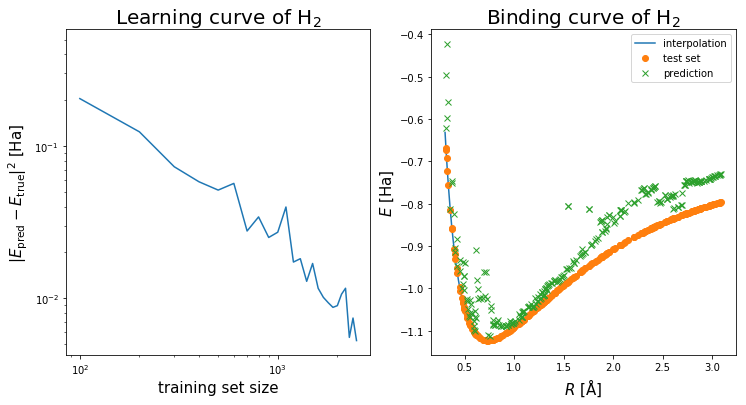

In [15]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12,6))

ax1.loglog(itr_list, err_list_test)
ax1.set_title('Learning curve of H$_2$', fontsize=20)
ax1.set_ylabel(r'$|E_{\mathrm{pred}} - E_{\mathrm{true}}|^2$ [Ha]', fontsize=15)
ax1.set_xlabel('training set size', fontsize=15)

ax2.plot(R, [inp.ht_ham.cache['energy']
             for inp in inps], label='interpolation')
ax2.plot(R_test, E_test, ls='', marker='o', label='test set')
ax2.plot(R_test, E_prd_list, ls='', marker='x', label='prediction')
#plt.plot(R_train, E_train, ls='', marker='x', label='training set')
ax2.legend(loc=1)
ax2.set_title(r'Binding curve of H$_2$', fontsize=20)
ax2.set_ylabel(r'$E$ [Ha]', fontsize=15)
ax2.set_xlabel(r'$R$ [$\mathrm{\AA}$]', fontsize=15)

## Density analysis
Visiualize predicted density

In [16]:
q_tar_list = []
q_prd_list = []
for i in range(len(inp_test)):
    inp = inp_test[i]
    C_prd = C_prd_list[i]
    dm_tar = inp.dm()
    q_tar_list.append(inp.get_rho_cube())
    dm_prd = inp.dm(C_prd)
    q_prd_list.append(inp.get_rho_cube(dm=dm_prd))

In [20]:
iq = 10
q_tar = q_tar_list[iq]
q_prd = q_prd_list[iq]
q_tar.name = 'q_tar'
q_prd.name = 'q_prd'

CUBE: center of mass on y-axis: 0.0 
CUBE: axis:1, slice:30.000000 
CUBE: slice coordinate: 0.000000 


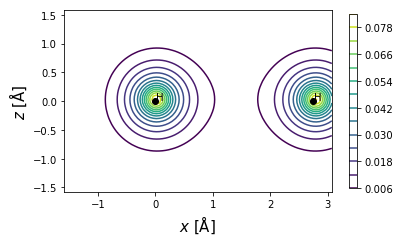

In [23]:
q_tar.contour(axis=1)
pass

CUBE: center of mass on y-axis: 0.0 
CUBE: axis:1, slice:30.000000 
CUBE: slice coordinate: 0.000000 


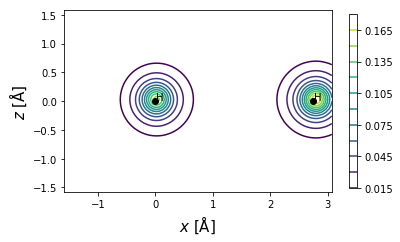

In [24]:
q_prd.contour(axis=1)
pass

## Final remarks

**There is learning**, as shown by the learning curve. This indicates that larger dataset and more complex model could perform better. However, for such simplistic case (H$_2$ with 3-21G basis) this learning rate is too slow. The MO coefficients will be at least 100$\times$100 matrix for some reasonable molecule dataset, instead of 4 $\times$ 4. 

**More complex model** can be constructed. The architecture employed here is simplistic. The input is **only** the initial guess of MO coefficients. All other Hamiltonian componenst are used only to construct energy prediction, except the canonical orthogonalization matrix $\mathbf{X}$. As a results, Hamiltonian gives very small contribution to the model prediction. In fact, the hidden layer employed here is a orthogonalization layer. Such orthogonalization is necessary only at the last layer. It would be meaningful to encode Hamiltonian into the netword architecture. For example, apply convolutional layers to stacked Hamiltonian component.